# HTTP Payload Anomaly Detection using LSTM Without Attention

# Cell 1: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from imblearn.over_sampling import SMOTE
import warnings

In [3]:
!unzip /content/HTTP.zip

Archive:  /content/HTTP.zip
  inflating: Test_data.csv           
  inflating: Train_data.csv          


# Cell 2: Load and Explore Data

Dataset shape: (25192, 42)

First 5 rows:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2          

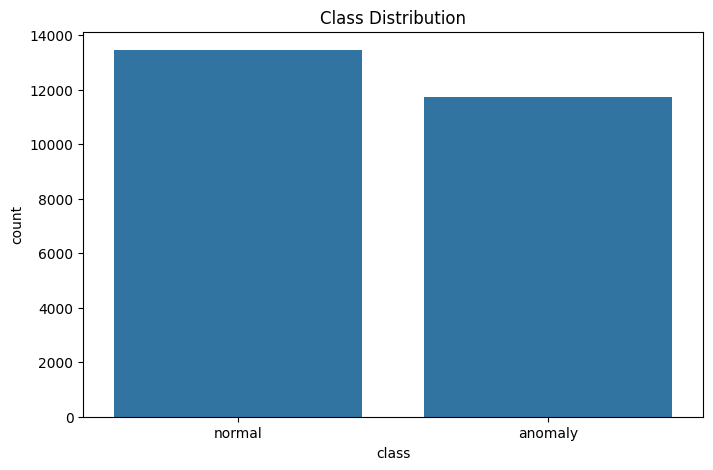

In [4]:
# Load the dataset
df = pd.read_csv('/content/Train_data.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types and missing values:")
print(df.info())
print("\nClass distribution:")
print(df['class'].value_counts())

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.show()

# Cell 3: Preprocess Data

In [5]:
# Convert categorical columns to numerical
categorical_cols = ['protocol_type', 'service', 'flag']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Convert target variable to binary (0 for normal, 1 for anomaly)
df['class'] = df['class'].apply(lambda x: 0 if x == 'normal' else 1)

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for LSTM (samples, timesteps, features)
# Since we don't have sequential data, we'll treat each sample as a sequence of 1 timestep
X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE
# Note: We need to reshape back to 2D for SMOTE
X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[2])
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_2d, y_train)

# Reshape back to 3D for LSTM
X_train_smote = X_train_smote.reshape(X_train_smote.shape[0], 1, X_train_smote.shape[1])

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())


Class distribution after SMOTE:
class
0    10759
1    10759
Name: count, dtype: int64


# Cell 4: Build LSTM Model

In [6]:
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Get input shape
input_shape = (X_train_smote.shape[1], X_train_smote.shape[2])

# Create model
model = create_lstm_model(input_shape)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        27,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,097 (156.63 KB)

 Trainable params: 40,097 (156.63 KB)

 Non-trainable params: 0 (0.00 B)

# Cell 5: Train the Model

In [7]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
330/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8895 - loss: 0.3802

337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8904 - loss: 0.3765 - val_accuracy: 0.9585 - val_loss: 0.1232
Epoch 2/50
325/337 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9615 - loss: 0.1101

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9615 - loss: 0.1101 - val_accuracy: 0.9645 - val_loss: 0.1066
Epoch 3/50
319/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9663 - loss: 0.0984

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9663 - loss: 0.0981 - val_accuracy: 0.9677 - val_loss: 0.0984
Epoch 4/50
326/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9703 - loss: 0.0857

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9703 - loss: 0.0857 - val_accuracy: 0.9704 - val_loss: 0.0872
Epoch 5/50
331/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9725 - loss: 0.0760

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9725 - loss: 0.0760 - val_accuracy: 0.9710 - val_loss: 0.0797
Epoch 6/50
335/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9729 - loss: 0.0727

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9729 - loss: 0.0726 - val_accuracy: 0.9740 - val_loss: 0.0731
Epoch 7/50
328/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9772 - loss: 0.0571

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9772 - loss: 0.0572 - val_accuracy: 0.9740 - val_loss: 0.0691
Epoch 8/50
330/337 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9792 - loss: 0.0549

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9792 - loss: 0.0549 - val_accuracy: 0.9750 - val_loss: 0.0672
Epoch 9/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9777 - loss: 0.0556 - val_accuracy: 0.9770 - val_loss: 0.0686
Epoch 10/50
335/337 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9809 - loss: 0.0489

337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9809 - loss: 0.0490 - val_accuracy: 0.9772 - val_loss: 0.0621
Epoch 11/50
325/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9805 - loss: 0.0510

337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9805 - loss: 0.0510 - val_accuracy: 0.9782 - val_loss: 0.0608
Epoch 12/50
334/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9802 - loss: 0.0498

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9803 - loss: 0.0498 - val_accuracy: 0.9780 - val_loss: 0.0604
Epoch 13/50
330/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9807 - loss: 0.0474

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9807 - loss: 0.0474 - val_accuracy: 0.9796 - val_loss: 0.0555
Epoch 14/50
333/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9818 - loss: 0.0460

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9818 - loss: 0.0460 - val_accuracy: 0.9817 - val_loss: 0.0535
Epoch 15/50
323/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9818 - loss: 0.0427

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9818 - loss: 0.0427 - val_accuracy: 0.9809 - val_loss: 0.0531
Epoch 16/50
327/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9843 - loss: 0.0389

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9842 - loss: 0.0390 - val_accuracy: 0.9839 - val_loss: 0.0499
Epoch 17/50
335/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9818 - loss: 0.0419

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9818 - loss: 0.0419 - val_accuracy: 0.9827 - val_loss: 0.0490
Epoch 18/50
332/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9850 - loss: 0.0406

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9850 - loss: 0.0406 - val_accuracy: 0.9839 - val_loss: 0.0452
Epoch 19/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9854 - loss: 0.0357 - val_accuracy: 0.9843 - val_loss: 0.0469
Epoch 20/50
331/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9867 - loss: 0.0352

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9866 - loss: 0.0352 - val_accuracy: 0.9841 - val_loss: 0.0446
Epoch 21/50
330/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9859 - loss: 0.0345

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9859 - loss: 0.0345 - val_accuracy: 0.9877 - val_loss: 0.0427
Epoch 22/50
333/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9877 - loss: 0.0324

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9877 - loss: 0.0324 - val_accuracy: 0.9877 - val_loss: 0.0399
Epoch 23/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9867 - loss: 0.0332 - val_accuracy: 0.9855 - val_loss: 0.0420
Epoch 24/50
331/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9878 - loss: 0.0298

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9879 - loss: 0.0299 - val_accuracy: 0.9873 - val_loss: 0.0379
Epoch 25/50
332/337 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9881 - loss: 0.0293

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9881 - loss: 0.0293 - val_accuracy: 0.9863 - val_loss: 0.0375
Epoch 26/50
328/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9893 - loss: 0.0289

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9893 - loss: 0.0289 - val_accuracy: 0.9869 - val_loss: 0.0374
Epoch 27/50
327/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9896 - loss: 0.0270

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9895 - loss: 0.0270 - val_accuracy: 0.9881 - val_loss: 0.0371
Epoch 28/50
328/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9907 - loss: 0.0238

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9907 - loss: 0.0239 - val_accuracy: 0.9893 - val_loss: 0.0363
Epoch 29/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9899 - loss: 0.0282 - val_accuracy: 0.9889 - val_loss: 0.0369
Epoch 30/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9901 - loss: 0.0270 - val_accuracy: 0.9887 - val_loss: 0.0390
Epoch 31/50
332/337 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9888 - loss: 0.0288

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9888 - loss: 0.0288 - val_accuracy: 0.9891 - val_loss: 0.0343
Epoch 32/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9880 - loss: 0.0282 - val_accuracy: 0.9891 - val_loss: 0.0367
Epoch 33/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9903 - loss: 0.0253 - val_accuracy: 0.9883 - val_loss: 0.0366
Epoch 34/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9904 - loss: 0.0252 - val_accuracy: 0.9899 - val_loss: 0.0374
Epoch 35/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9893 - loss: 0.0299 - val_accuracy: 0.9897 - val_loss: 0.0357
Epoch 36/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9907 - loss: 0.0254 - val_accuracy: 0.9903 - val_loss: 0.0352


# Cell 6: Evaluate the Model

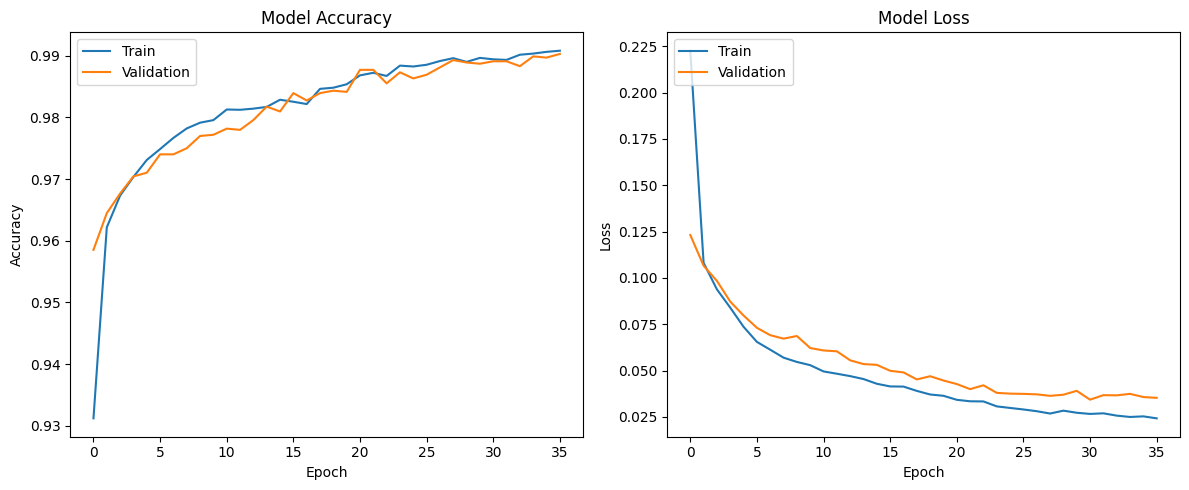

158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      2690
     Anomaly       0.99      0.99      0.99      2349

    accuracy                           0.99      5039
   macro avg       0.99      0.99      0.99      5039
weighted avg       0.99      0.99      0.99      5039



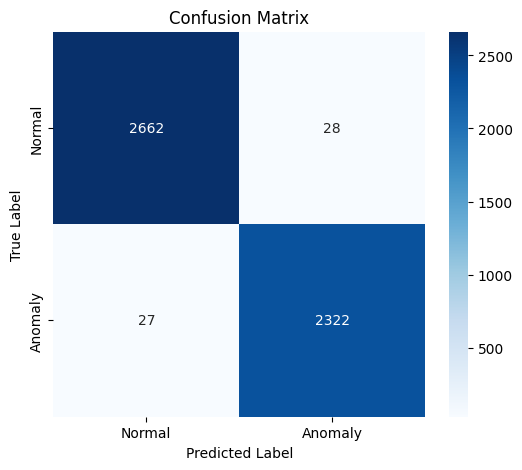


Accuracy: 0.9891
Precision: 0.9881
Recall: 0.9885
F1 Score: 0.9883


In [8]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [11]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=105555648e01ed599c6d460dae5a2dfdd377e2ed2a361f65636c7469e38650de
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [20]:
# Import required libraries
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Prepare ground truth and predictions for the anomaly detection task
y_true = ["normal" if label == "normal" else "anomaly" for label in y_test]
y_pred_label = ["normal" if pred > 0.5 else "anomaly" for pred in y_pred]

# BLEU Score with smoothing
reference_bleu = [[ref] for ref in y_true]
candidate_bleu = [[pred] for pred in y_pred_label]
smoothing_function = SmoothingFunction().method1
bleu = corpus_bleu(reference_bleu, candidate_bleu, smoothing_function=smoothing_function)

# ROUGE Scores
ref_text = " ".join(y_true)
cand_text = " ".join(y_pred_label)
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
rouge_scores = scorer.score(ref_text, cand_text)

# Classification Metrics
accuracy = accuracy_score(y_true, y_pred_label)
precision = precision_score(y_true, y_pred_label, pos_label="anomaly")
recall = recall_score(y_true, y_pred_label, pos_label="anomaly")
f1 = f1_score(y_true, y_pred_label, pos_label="anomaly")
class_report = classification_report(y_true, y_pred_label)

# Print all results
print(f"BLEU Score (with smoothing): {bleu:.4f}")
print(f"ROUGE-1: {rouge_scores['rouge1']}")
print(f"ROUGE-L: {rouge_scores['rougeL']}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(class_report)


BLEU Score (with smoothing): 0.0000
ROUGE-1: Score(precision=0.533637626513197, recall=0.533637626513197, fmeasure=0.533637626513197)
ROUGE-L: Score(precision=0.533637626513197, recall=0.533637626513197, fmeasure=0.533637626513197)
Accuracy: 0.5336
Precision: 1.0000
Recall: 0.5336
F1 Score: 0.6959

Classification Report:
              precision    recall  f1-score   support

     anomaly       1.00      0.53      0.70      5039
      normal       0.00      0.00      0.00         0

    accuracy                           0.53      5039
   macro avg       0.50      0.27      0.35      5039
weighted avg       1.00      0.53      0.70      5039



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Cell 7: Feature Importance Analysis

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


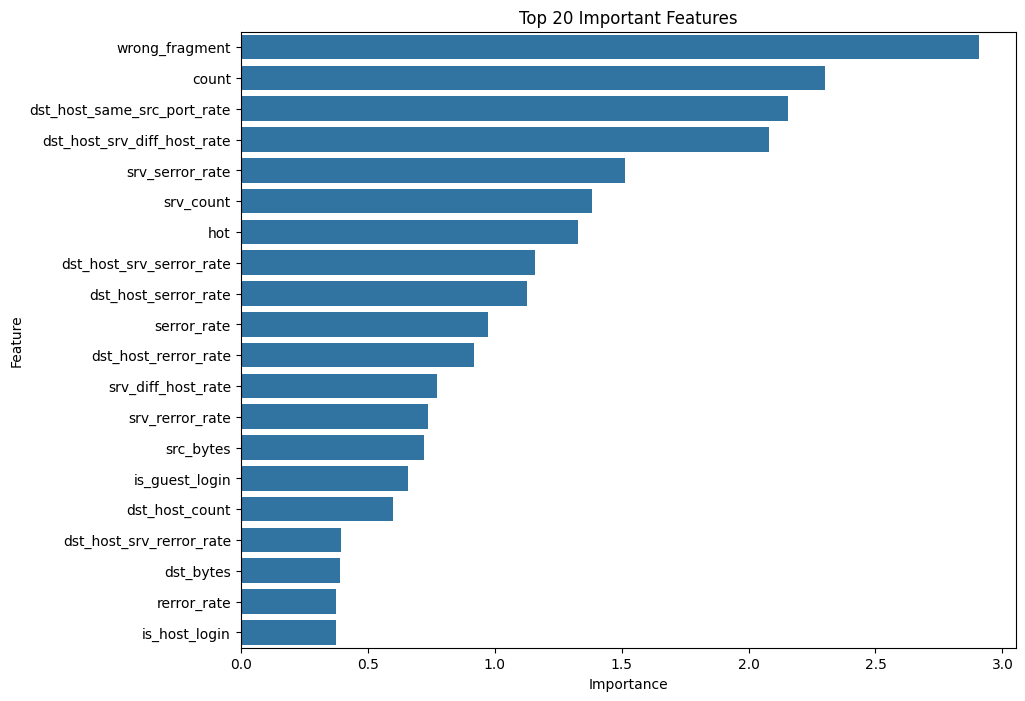

In [13]:
# Create a simple model to get feature weights
simple_model = Sequential([
    Dense(1, activation='sigmoid', input_shape=(X_train_smote.shape[2],))
])
simple_model.compile(optimizer='adam', loss='binary_crossentropy')
simple_model.fit(X_train_smote.reshape(-1, X_train_smote.shape[2]), y_train_smote, epochs=10, verbose=0)

# Get feature weights
weights = simple_model.layers[0].get_weights()[0].flatten()
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': weights
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Important Features')
plt.show()

# Cell 8: Anomaly Detection and Visualization

<ipython-input-14-019abbcad16f>:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


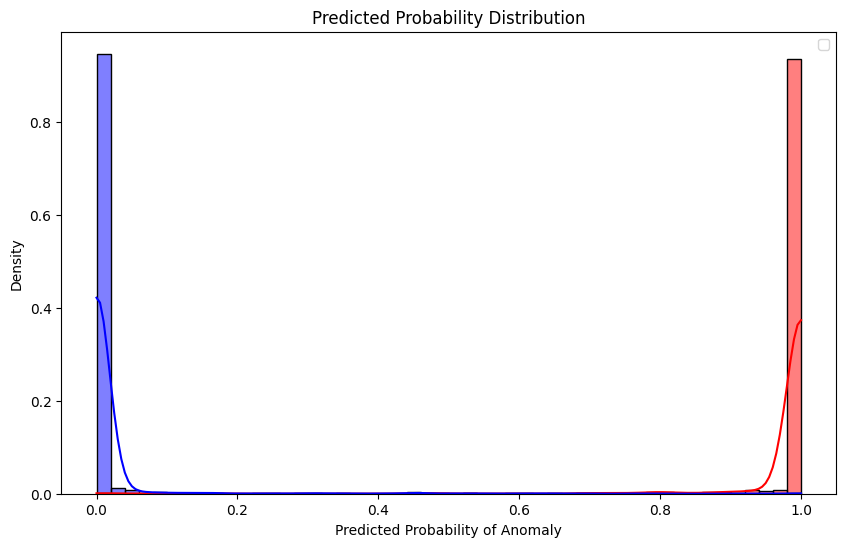


Threshold Analysis:
Default threshold (0.5): Accuracy = 0.9891
Optimal threshold (0.6857): Accuracy = 0.9905


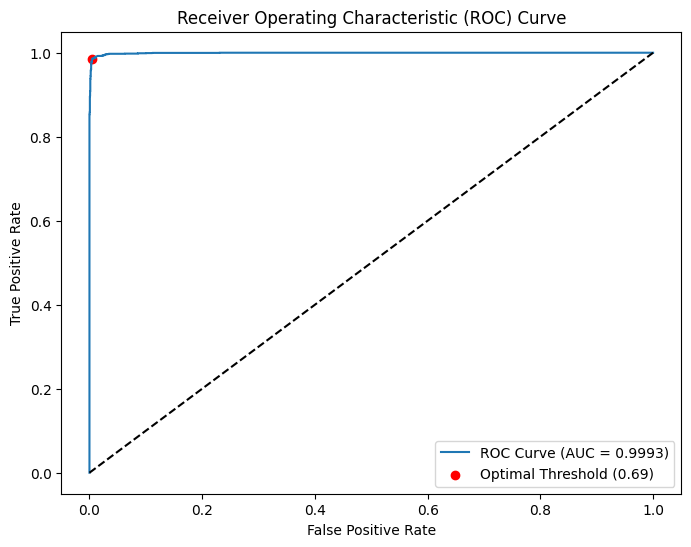

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

# Ensure y_test and y_pred_prob are 1D arrays
y_test = np.ravel(y_test)  # Flatten to 1D if needed
y_pred_prob = np.ravel(y_pred_prob)  # Flatten to 1D if needed

# 1. Probability Distribution Plot (optimized)
plt.figure(figsize=(10, 6))

# Create DataFrame with proper 1D arrays
plot_df = pd.DataFrame({
    'Probability': y_pred_prob,
    'Class': np.where(y_test == 0, 'Normal', 'Anomaly')
})

# Optional: Subsample if dataset is very large
if len(plot_df) > 10000:
    plot_df = plot_df.sample(10000, random_state=42)

sns.histplot(
    data=plot_df, x='Probability', hue='Class',
    palette={'Normal': 'blue', 'Anomaly': 'red'},
    kde=True,
    stat='probability',
    bins=50,
    common_norm=False
)

plt.title('Predicted Probability Distribution')
plt.xlabel('Predicted Probability of Anomaly')
plt.ylabel('Density')
plt.legend()
plt.show()

# 2. Optimal Threshold Calculation
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

print(f"\nThreshold Analysis:")
print(f"Default threshold (0.5): Accuracy = {accuracy_score(y_test, (y_pred_prob > 0.5).astype(int)):.4f}")
print(f"Optimal threshold ({optimal_threshold:.4f}): Accuracy = {accuracy_score(y_test, (y_pred_prob > optimal_threshold).astype(int)):.4f}")

# 3. ROC Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_prob):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.scatter(
    fpr[optimal_idx], tpr[optimal_idx],
    marker='o', color='red',
    label=f'Optimal Threshold ({optimal_threshold:.2f})'
)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Cell 9: Save the Model and Preprocessing Objects

In [15]:
import joblib

# Save the trained model
model.save('http_anomaly_detection_lstm.h5')

# Save preprocessing objects
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print("Model and preprocessing objects saved successfully.")

Model and preprocessing objects saved successfully.


#Cell 10:Example of Using the Model for Prediction

In [16]:
# Example of how to use the saved model for new predictions
def predict_anomaly(sample_data):
    """
    sample_data: A dictionary containing the raw feature values for one sample
    """
    # Convert to DataFrame
    sample_df = pd.DataFrame([sample_data])

    # Preprocess categorical features
    for col in categorical_cols:
        le = label_encoders[col]
        sample_df[col] = le.transform(sample_df[col])

    # Scale numerical features
    sample_scaled = scaler.transform(sample_df)

    # Reshape for LSTM
    sample_reshaped = sample_scaled.reshape(1, 1, sample_scaled.shape[1])

    # Make prediction
    prob = model.predict(sample_reshaped)[0][0]
    prediction = 1 if prob > 0.5 else 0

    return {
        'probability': float(prob),
        'prediction': 'Anomaly' if prediction == 1 else 'Normal',
        'threshold_used': 0.5
    }

# Example usage
sample = {
    'duration': 0,
    'protocol_type': 'tcp',
    'service': 'http',
    'flag': 'SF',
    'src_bytes': 232,
    'dst_bytes': 8153,
    # ... include all other features with their values
}

# Uncomment to test
# result = predict_anomaly(sample)
# print("\nPrediction Result:")
# print(result)